## Classification

In this section, I will fit the vectors given by BoW and TF-IDF model to various machine learning models including logistic regression (already did), naive bayes, SVM, decision tree, LightGBM and XGBoost, and ensemble learning, use grid search to fine tune parameters and use several metrics to evaluate model performance.

The accuracy and f-1 score of the baseline model (TF-IDF + logistic regression) is 0.788 and 0.786.

In order to improve model performance, I tried to do more feature engineering before training the model.

First, I constructed a customized stopword list consisting of the drug names, conditions, and other word including day, week, month, take, etc. The logic behind this is that I noticed that a lot of reviews contain drug names and conditions, but the context does does not contain any significant positive or negative feelings. This is also the case for days, weeks and months, which usually appear in sentences like "I have taken the drug for 10 days, ...". Such words might not show strong sentiment and thus do not contribute to the performance of the model.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('../Datasets/drugsComTrain_raw.tsv',sep='\t')
print("The Shape of the Dataset :", data.shape)

The Shape of the Dataset : (161297, 7)


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/teja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/teja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
data.groupby(['condition']).count()['review'][80:90]

condition
Acne                                     5588
Actinic Keratosis                          29
Acute Coronary Syndrome                    54
Acute Lymphoblastic Leukemia                4
Acute Nonlymphocytic Leukemia               1
Acute Promyelocytic Leukemia                3
Addison's Disease                          11
Adrenocortical Insufficiency                8
Adult Human Growth Hormone Deficiency      10
Aggressive Behavi                           2
Name: review, dtype: int64

In [5]:
'''
'pain', 'flash', 
                  'headache', 'obesity', 'obsessive', 'disorder', 'panic', 'Dysphoric',
                  'Peripheral', 'Neuropathy', 'Sedation', 'sedation', 
                  '''

"\n'pain', 'flash', \n                  'headache', 'obesity', 'obsessive', 'disorder', 'panic', 'Dysphoric',\n                  'Peripheral', 'Neuropathy', 'Sedation', 'sedation', \n                  "

In [6]:
drug_name = ['lexapro', 'zoloft', 'prozac', 'paxil', 'celexa', 'cymbalta', 'pristiq',
             'effexor', 'bupropion', 'mirtazapine', 'trazodone', 'vilazodone',
             'vortioxetine', 'trintellix', 'viibryd', 'wellbutrin', 'bupropion', 
             'wellbutrin', 'mg', 'xl', 'sr', 'budeprion', 'sedyrel', 'aplenzin',
             'buproban', 'forfivo', 'oleptro', 'remeron', 'soltab', 
             'vortioxetine', 'viibryd', 'zyban']
condition_name = ['depression', 'anxiety']
other = ['day', 'week', 'month', 'year', 'take']

customized_stopwords = drug_name+other

In [7]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/teja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
from nltk.stem.snowball import SnowballStemmer
import spacy

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
# Lemmatize with POS Tag
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

stemmed_stopwords = []
'''
for w in customized_stopwords:
    stemmed_stopwords.append(SnowballStemmer('english').stem(lemmatizer.lemmatize(w, get_wordnet_pos(w))))
'''

for w in customized_stopwords:
    stemmed_stopwords.append(SnowballStemmer('english').stem(w))

2022-08-25 15:50:34.020468: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-25 15:50:34.023153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 15:50:34.023165: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-25 15:50:34.906450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-25 15:50:34.906475: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to c

In [9]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/teja/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
stemmed_stopwords

['lexapro',
 'zoloft',
 'prozac',
 'paxil',
 'celexa',
 'cymbalta',
 'pristiq',
 'effexor',
 'bupropion',
 'mirtazapin',
 'trazodon',
 'vilazodon',
 'vortioxetin',
 'trintellix',
 'viibryd',
 'wellbutrin',
 'bupropion',
 'wellbutrin',
 'mg',
 'xl',
 'sr',
 'budeprion',
 'sedyrel',
 'aplenzin',
 'buproban',
 'forfivo',
 'oleptro',
 'remeron',
 'soltab',
 'vortioxetin',
 'viibryd',
 'zyban',
 'day',
 'week',
 'month',
 'year',
 'take']

In [11]:
import string 
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import feature_extraction
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import spacy
from tqdm import tqdm

In [12]:
# delete all the records where Condition or rating is Missing
data = data.dropna()

In [13]:
# First remove Punctuations from the Reviews
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str
data['review'] = data['review'].apply(punctuation_removal)

In [14]:
## remove special symbol
def rm_sym(df):
    df['review'] = df['review'].str.replace("&#039;",'\'')
    df['review'].head()
    return df
data = rm_sym(data)

In [15]:
def normalize_whitespace(text):
    """
    This function normalizes whitespaces, removing duplicates.
    """
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")

#data['review']=data['review'].apply(lambda x: normalize whitespace(x))

In [16]:
def tokenize(text):
    split=re.split("\W+",text)
    split=split[1:-1]
    return split
data['review_list']=data['review'].apply(lambda x: tokenize(x.lower()))
#data['review_list'].head()

In [17]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)
data['review']=data['review_list'].apply(lambda x: drop_numbers(x))
data['review_list']=data['review'].apply(lambda x: tokenize(x))

In [ ]:
def lemmatize(word_list):
    lemmatized = []
    for w in word_list:
        lemmatized.append(lemmatizer.lemmatize(w, get_wordnet_pos(w)))
    return lemmatized

data['review_list']=data['review_list'].apply(lambda x: lemmatize(x))

In [18]:
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

data['review_list'] = data['review_list'].apply(lambda x: remove_stopwords(x))


In [19]:
from nltk.stem.snowball import SnowballStemmer

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

stemmer = SnowballStemmer('english')
data['review_list'] = data['review_list'].apply(lambda x: stem_tokens(x, stemmer=stemmer))

In [20]:
data['review_list']

0                  [side, effect, take, combin, bystol, mg]
1         [halfway, fourth, week, intuniv, becam, concer...
2         [take, anoth, oral, contracept, pill, cycl, ha...
3         [first, time, use, form, birth, control, glad,...
4         [complet, turn, life, around, feel, healthier,...
                                ...                        
161292    [first, report, midoctob, alcohol, sinc, post,...
161293    [given, iv, surgey, immedi, becam, anxious, co...
161294               [month, develop, bad, rash, md, refus]
161295    [thyroid, medic, year, spent, first, synthroid...
161296    [chronic, constip, adult, life, tri, linzess, ...
Name: review_list, Length: 160398, dtype: object

In [21]:
def combine(list_text):
    list_text_new = []
    for i in list_text:
        list_text_new.append(i)
    return ' '.join(list_text_new)
data['review']=data['review_list'].apply(lambda x: combine(x))

In [22]:
data['review']

0                         side effect take combin bystol mg
1         halfway fourth week intuniv becam concern bega...
2         take anoth oral contracept pill cycl happi lig...
3         first time use form birth control glad went pa...
4         complet turn life around feel healthier excel ...
                                ...                        
161292    first report midoctob alcohol sinc post reduc ...
161293    given iv surgey immedi becam anxious could sit...
161294                      month develop bad rash md refus
161295    thyroid medic year spent first synthroid vario...
161296    chronic constip adult life tri linzess work mo...
Name: review, Length: 160398, dtype: object

In [23]:
def remove_customized_stopwords(text):
    text=[word for word in text if word not in stemmed_stopwords]
    return text

data['review_list_new'] = data['review_list'].apply(lambda x: remove_customized_stopwords(x))

In [24]:
data['review_list_new']
data['review_new']=data['review_list_new'].apply(lambda x: combine(x))

In [25]:
data['review_new']

0                                 side effect combin bystol
1         halfway fourth intuniv becam concern began las...
2         anoth oral contracept pill cycl happi light pe...
3         first time use form birth control glad went pa...
4         complet turn life around feel healthier excel ...
                                ...                        
161292    first report midoctob alcohol sinc post reduc ...
161293    given iv surgey immedi becam anxious could sit...
161294                            develop bad rash md refus
161295    thyroid medic spent first synthroid various fo...
161296    chronic constip adult life tri linzess work st...
Name: review_new, Length: 160398, dtype: object

In [26]:
# transform the ratings to three categories: positive, neutral and negative
def transform_rating(df):
    df['sentiment'] = ''
    df.loc[df['rating'] >= 7,'sentiment'] = 'positive'
    df.loc[df['rating'] <= 4,'sentiment'] = 'negative'
    df.loc[(df['rating'] > 4) & (df['rating'] < 7),'sentiment'] = 'neutral'
    return df
data = transform_rating(data)

# split the dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.25)

In [27]:
## only need to remove punctuation and stemize
stemmer = SnowballStemmer('english')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [28]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [29]:
## Generate table of words with their counts
## TfidfVectorizer transform train and test
con_vec_tf = TfidfVectorizer(max_features = 10000, ngram_range = (1, 3))
X_train_tf = con_vec_tf.fit_transform(train['review'])
y_train = train['sentiment']
X_test_tf = con_vec_tf.transform(test['review'])
y_test = test['sentiment']

print(X_train_tf.shape)
print(X_test_tf.shape)

(120298, 10000)
(40100, 10000)


In [30]:
con_vec_tf = TfidfVectorizer(max_features = 20000, ngram_range = (1, 3))
X_train_tf_new = con_vec_tf.fit_transform(train['review'])
y_train = train['sentiment']
X_test_tf_new = con_vec_tf.transform(test['review'])
y_test = test['sentiment']

### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

clf_tf = LogisticRegression(C=30.0, class_weight='balanced', solver='sag', 
                             multi_class='multinomial', n_jobs=-1, random_state=40, 
                             verbose=1, max_iter = 1000)
clf_tf.fit(X_train_tf, y_train)
y_predicted_tf = clf_tf.predict(X_test_tf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


 change: 0.49792556
Epoch 961, change: 0.52434345
Epoch 962, change: 0.58950485
Epoch 963, change: 0.65684581
Epoch 964, change: 0.50025190
Epoch 965, change: 0.48944668
Epoch 966, change: 0.54885206
Epoch 967, change: 0.63819675
Epoch 968, change: 0.53784631
Epoch 969, change: 0.48602463
Epoch 970, change: 0.45881373
Epoch 971, change: 0.60495403
Epoch 972, change: 0.52453996
Epoch 973, change: 0.50521783
Epoch 974, change: 0.55981074
Epoch 975, change: 0.55539458
Epoch 976, change: 0.60056340
Epoch 977, change: 0.61817131
Epoch 978, change: 0.53428325
Epoch 979, change: 0.52163211
Epoch 980, change: 0.48445247
Epoch 981, change: 0.49874825
Epoch 982, change: 0.55545113
Epoch 983, change: 0.51996409
Epoch 984, change: 0.52115695
Epoch 985, change: 0.53943522
Epoch 986, change: 0.59635050
Epoch 987, change: 0.57827155
Epoch 988, change: 0.44660124
Epoch 989, change: 0.48075750
Epoch 990, change: 0.44459069
Epoch 991, change: 0.48739560
Epoch 992, change: 0.49457237
Epoch 993, change: 0

Epoch 373, change: 0.49288826
Epoch 374, change: 0.52333220
Epoch 375, change: 0.51505853
Epoch 376, change: 0.62291434
Epoch 377, change: 0.58263352
Epoch 378, change: 0.50433284
Epoch 379, change: 0.45622435
Epoch 380, change: 0.43005841
Epoch 381, change: 0.47862278
Epoch 382, change: 0.50132448
Epoch 383, change: 0.44068528
Epoch 384, change: 0.49236460
Epoch 385, change: 0.44271210
Epoch 386, change: 0.41467388
Epoch 387, change: 0.46752010
Epoch 388, change: 0.47608709
Epoch 389, change: 0.44919213
Epoch 390, change: 0.45381487
Epoch 391, change: 0.48413433
Epoch 392, change: 0.51365579
Epoch 393, change: 0.47340885
Epoch 394, change: 0.50110417
Epoch 395, change: 0.52582933
Epoch 396, change: 0.49269398
Epoch 397, change: 0.58473410
Epoch 398, change: 0.61837877
Epoch 399, change: 0.61081768
Epoch 400, change: 0.47930729
Epoch 401, change: 0.50085811
Epoch 402, change: 0.45264255
Epoch 403, change: 0.51542325
Epoch 404, change: 0.53520123
Epoch 405, change: 0.56122073
Epoch 406,

Epoch 646, change: 0.50733672
Epoch 647, change: 0.59885045
Epoch 648, change: 0.53813730
Epoch 649, change: 0.59394245
Epoch 650, change: 0.49627870
Epoch 651, change: 0.49302133
Epoch 652, change: 0.48406918
Epoch 653, change: 0.54126092
Epoch 654, change: 0.55524300
Epoch 655, change: 0.52943041
Epoch 656, change: 0.52252912
Epoch 657, change: 0.59055947
Epoch 658, change: 0.53527067
Epoch 659, change: 0.51866275
Epoch 660, change: 0.42029304
Epoch 661, change: 0.48748041
Epoch 662, change: 0.55285737
Epoch 663, change: 0.45450467
Epoch 664, change: 0.52203288
Epoch 665, change: 0.42824988
Epoch 666, change: 0.51915593
Epoch 667, change: 0.50400953
Epoch 668, change: 0.51154570
Epoch 669, change: 0.50492553
Epoch 670, change: 0.44760501
Epoch 671, change: 0.50771361
Epoch 672, change: 0.50188747
Epoch 673, change: 0.59381049
Epoch 674, change: 0.51598584
Epoch 675, change: 0.52702868
Epoch 676, change: 0.45008396
Epoch 677, change: 0.51179516
Epoch 678, change: 0.50478751
Epoch 679,

Epoch 919, change: max_iter reached after 123 seconds


/home/teja/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.1min finished


In [33]:
accuracy_tf, precision_tf, recall_tf, f1_tf = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tf, precision_tf, 
                                                                       recall_tf, f1_tf))

accuracy = 0.638, precision = 0.746, recall = 0.638, f1 = 0.671


In [34]:
from sklearn.linear_model import LogisticRegression

clf_tf_new = LogisticRegression(C=30.0, class_weight='balanced', solver='sag', 
                             multi_class='multinomial', n_jobs=-1, random_state=40, 
                             verbose=1, max_iter = 1000)
clf_tf_new.fit(X_train_tf_new, y_train)
y_predicted_tf_new = clf_tf_new.predict(X_test_tf_new)
accuracy_tf, precision_tf, recall_tf, f1_tf = get_metrics(y_test, y_predicted_tf_new)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tf, precision_tf, 
                                                                       recall_tf, f1_tf))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


0.55282131
Epoch 920, change: 0.45725500
Epoch 921, change: 0.50327799
Epoch 922, change: 0.49470139
Epoch 923, change: 0.48790387
Epoch 924, change: 0.52625260
Epoch 925, change: 0.54641485
Epoch 926, change: 0.48000620
Epoch 927, change: 0.59524626
Epoch 928, change: 0.57414154
Epoch 929, change: 0.48653114
Epoch 930, change: 0.52267909
Epoch 931, change: 0.54179011
Epoch 932, change: 0.49657162
Epoch 933, change: 0.50698067
Epoch 934, change: 0.46124657
Epoch 935, change: 0.51528992
Epoch 936, change: 0.50116196
Epoch 937, change: 0.46865164
Epoch 938, change: 0.55369951
Epoch 939, change: 0.44682116
Epoch 940, change: 0.44313679
Epoch 941, change: 0.50978764
Epoch 942, change: 0.46587019
Epoch 943, change: 0.47746834
Epoch 944, change: 0.47655009
Epoch 945, change: 0.48921924
Epoch 946, change: 0.51045291
Epoch 947, change: 0.55704238
Epoch 948, change: 0.44380790
Epoch 949, change: 0.43883992
Epoch 950, change: 0.45466773
Epoch 951, change: 0.47999260
Epoch 952, change: 0.50938286

Epoch 332, change: 0.38517395
Epoch 333, change: 0.45055019
Epoch 334, change: 0.50656555
Epoch 335, change: 0.41659875
Epoch 336, change: 0.41784995
Epoch 337, change: 0.38559438
Epoch 338, change: 0.38664097
Epoch 339, change: 0.54315062
Epoch 340, change: 0.52776700
Epoch 341, change: 0.48897562
Epoch 342, change: 0.42427592
Epoch 343, change: 0.43405919
Epoch 344, change: 0.43724478
Epoch 345, change: 0.43407145
Epoch 346, change: 0.50497421
Epoch 347, change: 0.38931886
Epoch 348, change: 0.45659469
Epoch 349, change: 0.45912577
Epoch 350, change: 0.49790274
Epoch 351, change: 0.47928751
Epoch 352, change: 0.40333158
Epoch 353, change: 0.43160144
Epoch 354, change: 0.40414610
Epoch 355, change: 0.45164978
Epoch 356, change: 0.41093046
Epoch 357, change: 0.51429698
Epoch 358, change: 0.51211958
Epoch 359, change: 0.43604938
Epoch 360, change: 0.37720005
Epoch 361, change: 0.35551149
Epoch 362, change: 0.44402612
Epoch 363, change: 0.39888254
Epoch 364, change: 0.44910463
Epoch 365,

Epoch 605, change: 0.43087104
Epoch 606, change: 0.52144059
Epoch 607, change: 0.48589708
Epoch 608, change: 0.38573170
Epoch 609, change: 0.41262021
Epoch 610, change: 0.50250228
Epoch 611, change: 0.45144882
Epoch 612, change: 0.45129974
Epoch 613, change: 0.39758486
Epoch 614, change: 0.51187392
Epoch 615, change: 0.43765267
Epoch 616, change: 0.34494592
Epoch 617, change: 0.38122952
Epoch 618, change: 0.37648261
Epoch 619, change: 0.52539042
Epoch 620, change: 0.39978764
Epoch 621, change: 0.44679009
Epoch 622, change: 0.44260242
Epoch 623, change: 0.41849130
Epoch 624, change: 0.41055861
Epoch 625, change: 0.41940883
Epoch 626, change: 0.40630064
Epoch 627, change: 0.41164856
Epoch 628, change: 0.43874795
Epoch 629, change: 0.48023665
Epoch 630, change: 0.61265386
Epoch 631, change: 0.49089334
Epoch 632, change: 0.71102578
Epoch 633, change: 0.49384859
Epoch 634, change: 0.45702849
Epoch 635, change: 0.48499431
Epoch 636, change: 0.49771895
Epoch 637, change: 0.42046536
Epoch 638,

Epoch 878, change: 0.3991758max_iter reached after 136 seconds


/home/teja/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.3min finished


accuracy = 0.717, precision = 0.772, recall = 0.717, f1 = 0.737


Accuracy: 6.4e-01
Auc: 0.8
Detail:
              precision    recall  f1-score   support

    negative       0.55      0.70      0.61     10064
     neutral       0.19      0.45      0.27      3514
    positive       0.90      0.64      0.75     26522

    accuracy                           0.64     40100
   macro avg       0.54      0.60      0.54     40100
weighted avg       0.75      0.64      0.67     40100



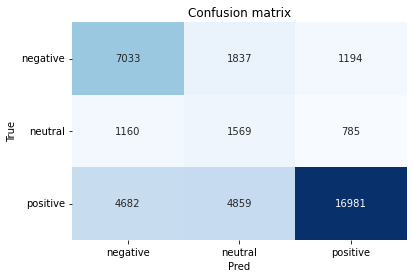

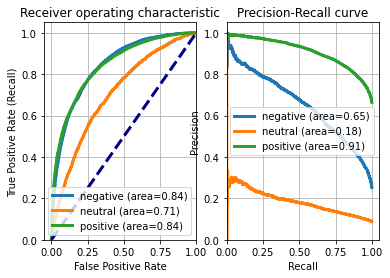

In [35]:
predicted = y_predicted_tf
predicted_prob = clf_tf.predict_proba(X_test_tf)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

Accuracy: 7.2e-01
Auc: 0.83
Detail:
              precision    recall  f1-score   support

    negative       0.64      0.69      0.66     10064
     neutral       0.27      0.51      0.35      3514
    positive       0.89      0.75      0.82     26522

    accuracy                           0.72     40100
   macro avg       0.60      0.65      0.61     40100
weighted avg       0.77      0.72      0.74     40100



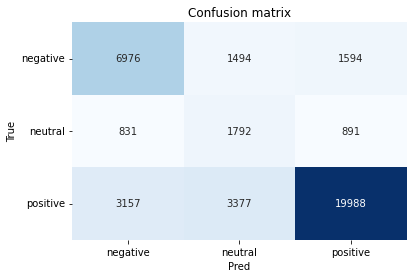

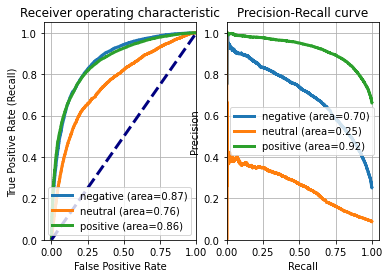

In [36]:
predicted = y_predicted_tf_new
predicted_prob = clf_tf_new.predict_proba(X_test_tf_new)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [37]:
coef_lr = pd.DataFrame(clf_tf_new.coef_,columns=con_vec_tf.get_feature_names(),index=clf_tf_new.classes_)

/home/teja/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
from PIL import Image
import PIL.ImageOps 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

thumb_up= np.array(Image.open("70420.png"))
thumb_up = 255 - thumb_up
thumb_down = np.fliplr(thumb_up)[::-1]

def top_20_pos_neg_wordcloud(category,mask):

    print('Rating as "' + category +'": top 20 of Positive coeffients')
    #print(coef_lr.loc[category].nlargest(20))

    print('\nRating as "' + category +'": top 20 of Negative coeffients')
    #print(coef_lr.loc[category].nsmallest(20))

    wordcloud = WordCloud(contour_width=1,background_color='white',mask=mask)
    wordcloud.generate_from_frequencies(frequencies=coef_lr.loc[category])

    #plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    
plt.figure(figsize=(20,10)) 
plt.subplot(1, 2, 1)
top_20_pos_neg_wordcloud('positive',thumb_up)
plt.title("Positive",fontsize=30)

plt.subplot(1, 2, 2)
top_20_pos_neg_wordcloud('negative',thumb_down)
plt.title("Negative",fontsize=30)

plt.savefig('thumb_up_down_wordcloud.png', bbox_inches = 'tight', pad_inches = 0)

FileNotFoundError: [Errno 2] No such file or directory: '70420.png'

### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score

In [40]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 600, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [300, 450, 600], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [42]:
rfc = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rfc_cv_score = cross_val_score(rfc,X_train_tf,y_train,scoring='accuracy',cv=3,n_jobs=-1)
rfc_cv_score

array([0.80381546, 0.80433427, 0.80388538])

In [43]:
#rfc = RandomForestClassifier(n_estimators=400,n_jobs=-1)
#rfc_cv_score = cross_val_score(rfc,X_train_tf_new,y_train,scoring='accuracy',cv=3,n_jobs=-1)
#rfc_cv_score
rfc = RandomForestClassifier(n_estimators=400,n_jobs=-1,oob_score=True, min_samples_leaf=1,
                             min_samples_split=2)
rfc.fit(X_train_tf_new,y_train)
y_test_rfc_predict = rfc.predict(X_test_tf_new)
rfc_conf_mat = confusion_matrix(y_test,y_test_rfc_predict)
accuracy_score(y_test,y_test_rfc_predict)

0.8474314214463841

In [44]:
#rfc = RandomForestClassifier(n_estimators=400,n_jobs=-1)
#rfc_cv_score = cross_val_score(rfc,X_train_tf_new,y_train,scoring='accuracy',cv=3,n_jobs=-1)
#rfc_cv_score
rfc = RandomForestClassifier(n_estimators=600,n_jobs=-1,oob_score=True, min_samples_leaf=1,
                             min_samples_split=2)
rfc.fit(X_train_tf_new,y_train)
y_test_rfc_predict = rfc.predict(X_test_tf_new)
rfc_conf_mat = confusion_matrix(y_test,y_test_rfc_predict)
accuracy_score(y_test,y_test_rfc_predict)

0.848004987531172

In [45]:
accuracy_rf, precision_rf, recall_rf, f1_rf = get_metrics(y_test, y_test_rfc_predict)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_rf, precision_rf, 
                                                                       recall_rf, f1_rf))

accuracy = 0.848, precision = 0.866, recall = 0.848, f1 = 0.835


In [46]:
predicted = y_test_rfc_predict
predicted_prob = rfc.predict_proba(X_test_tf)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

ValueError: X has 10000 features, but RandomForestClassifier is expecting 20000 features as input.

/home/teja/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


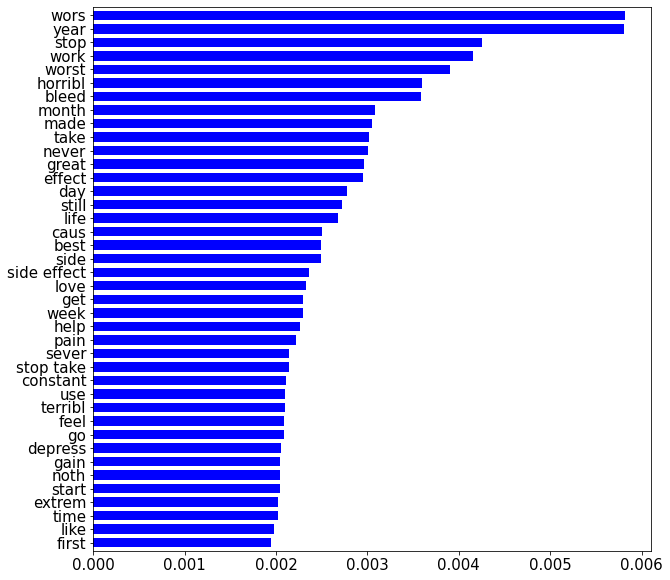

In [47]:
rfc_feature_importances = pd.DataFrame(rfc.feature_importances_,con_vec_tf.get_feature_names())
plt.figure(figsize=(10,10))
rfc_feature_importances[0].nlargest(40)[::-1].plot(kind='barh',color='blue',fontsize=15,width=0.7)
plt.savefig("rfc_feat_import.png")

### SVM

In [ ]:
from sklearn import svm

svm = svm.SVC(kernel='poly', degree=2, probability=True)

svm.fit(X_train_tf_new, y_train)
y_predicted_svm = svm.predict(X_test_tf_new)

In [ ]:
accuracy_svm, precision_svm, recall_svm, f1_svm = get_metrics(y_test, y_predicted_svm)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_svm, precision_svm, 
                                                                       recall_svm, f1_svm))

In [ ]:
accuracy_svm, precision_svm, recall_svm, f1_svm = get_metrics(y_test, y_predicted_svm)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_svm, precision_svm, 
                                                                       recall_svm, f1_svm))

In [ ]:
from sklearn import svm

svm = svm.SVC(kernel='rbf', probability=True)

svm.fit(X_train_tf_new, y_train)
y_predicted_svm = svm.predict(X_test_tf_new)

In [ ]:
accuracy_svm, precision_svm, recall_svm, f1_svm = get_metrics(y_test, y_predicted_svm)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_svm, precision_svm, 
                                                                       recall_svm, f1_svm))

In [ ]:
predicted = y_predicted_svm
predicted_prob = svm.predict_proba(X_test_tf_new)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tf_new, y_train)
y_predicted_nb = nb.predict(X_test_tf_new)

In [ ]:
accuracy_nb, precision_nb, recall_nb, f1_nb = get_metrics(y_test, y_predicted_nb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_nb, precision_nb, 
                                                                       recall_nb, f1_nb))

In [ ]:
predicted = y_predicted_nb
predicted_prob = nb.predict_proba(X_test_tf_new)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier 
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1)
abc.fit(X_train_tf_new, y_train)
y_predicted_abc = abc.predict(X_test_tf_new)

In [ ]:
accuracy_abc, precision_abc, recall_abc, f1_abc = get_metrics(y_test, y_predicted_abc)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_abc, precision_abc, 
                                                                       recall_abc, f1_abc))

In [ ]:
predicted = y_predicted_abc
predicted_prob = abc.predict_proba(X_test_tf_new)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, plot_confusion_matrix, roc_curve
xgb_model = xgb.XGBClassifier(random_state=6, use_label_encoder=False, n_jobs=-1)

In [ ]:
lr = [0.05,0.1]
max_depth=np.arange(5,10)
n_estimators=[500, 1000, 1500]
#gamma=np.arange(0,0.1,0.01)

param_grid = dict(learning_rate=lr, max_depth=max_depth, n_estimators=n_estimators)

grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=5)
grid_result = grid_search.fit(X_train_tf_new, y_train)

result_lgr = pd.DataFrame(grid_result.cv_results_)
result_lgr.sort_values(by='mean_test_score', ascending=False)[:4]

In [ ]:
import xgboost as xgb

xgb = xgb.XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 6, alpha = 10, n_estimators = 500)
xgb.fit(X_train_tf_new, y_train)
y_predicted_xgb = xgb.predict(X_test_tf_new)

In [ ]:
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_xgb, precision_xgb, 
                                                                       recall_xgb, f1_xgb))

In [ ]:
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_xgb, precision_xgb, 
                                                                       recall_xgb, f1_xgb))

In [ ]:
import xgboost as xgb

xgb = xgb.XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 6, alpha = 10, n_estimators = 1000)
xgb.fit(X_train_tf_new, y_train)
y_predicted_xgb = xgb.predict(X_test_tf_new)
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_xgb, precision_xgb, 
                                                                       recall_xgb, f1_xgb))

In [ ]:
import xgboost as xgb

xgb = xgb.XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 6, n_estimators = 1000)
xgb.fit(X_train_tf_new, y_train)
y_predicted_xgb = xgb.predict(X_test_tf_new)
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_xgb, precision_xgb, 
                                                                       recall_xgb, f1_xgb))

In [ ]:
import xgboost as xgb

xgb = xgb.XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 9, alpha = 10, n_estimators = 1000)
xgb.fit(X_train_tf_new, y_train)
y_predicted_xgb = xgb.predict(X_test_tf_new)
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_xgb, precision_xgb, 
                                                                       recall_xgb, f1_xgb))

In [ ]:
import xgboost as xgb

xgb = xgb.XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 6, alpha = 10, n_estimators = 1000)
xgb.fit(X_train_tf, y_train)
y_predicted_xgb = xgb.predict(X_test_tf)

In [ ]:
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_xgb, precision_xgb, 
                                                                       recall_xgb, f1_xgb))

In [ ]:
import xgboost as xgb

xgb = xgb.XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 6, alpha = 10, n_estimators = 1000)
xgb.fit(X_train_tf_new, y_train)
y_predicted_xgb = xgb.predict(X_test_tf_new)

In [ ]:
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = get_metrics(y_test, y_predicted_xgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_xgb, precision_xgb, 
                                                                       recall_xgb, f1_xgb))

In [ ]:
predicted = y_predicted_xgb
predicted_prob = xgb.predict_proba(X_test_tf)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### LightGBM

In [ ]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
lgb.fit(X_train_tf_new, y_train)
y_predicted_lgb = lgb.predict(X_test_tf_new)

In [ ]:
accuracy_lgb, precision_lgb, recall_lgb, f1_lgb = get_metrics(y_test, y_predicted_lgb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_lgb, precision_lgb, 
                                                                       recall_lgb, f1_lgb))

In [ ]:
predicted = y_predicted_lgb
predicted_prob = lgb.predict_proba(X_test_tf_new)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## Ensemble Learning

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

rfClf = RandomForestClassifier(n_estimators=500, random_state=0) # 500 trees. 
svmClf = SVC(probability=True, random_state=0) # probability calculation
logClf = LogisticRegression(random_state=0)
#nbclf = GaussianNB(random_state=0)

# constructing the ensemble classifier by mentioning the individual classifiers.
clf2 = VotingClassifier(estimators = [('rf',rfClf), ('svm',svmClf), ('log', logClf)], voting='soft') 

# train the ensemble classifier
clf2.fit(X_train_tf_new, y_train)

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('SVC', svm), ('LogReg', clf_tf), ('XGB', xgb)], voting='hard')
voting_clf.fit(X_train_tf_new, y_train)
preds = voting_clf.predict(X_test_tf_new)
acc = accuracy_score(y_test, preds)
acc

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('SVC', svm), ('LogReg', clf_tf), ('XGB', xgb)], voting='soft')
voting_clf.fit(X_train_tf_new, y_train)
preds = voting_clf.predict(X_test_tf_new)
acc = accuracy_score(y_test, preds)
acc

In [ ]:
predicted = preds
predicted_prob = voting_clf.predict_proba(X_test_tf_new)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import BaggingClassifier

logreg_bagging_model = BaggingClassifier(base_estimator=clf_tf, n_estimators=50, random_state=12)
logreg_bagging_model.fit(X_train_tf_new, y_train)
preds_log = logreg_bagging_model.predict(X_test_tf_new)
acc_log = accuracy_score(y_test, preds_log)
acc_log

In [ ]:
predicted = preds_log
predicted_prob = logreg_bagging_model.predict_proba(X_test_tf_new)

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()